In [1]:
# Load modules
import datacube
import os
import sys
import warnings
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.image as mpimg
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from matplotlib import pyplot as plt
import geopandas as gp
import fiona
import glob
from datacube import helpers

import rasterio
import sklearn
import graphviz 
import pdb
import sklearn
from rasterio.features import rasterize

# Import external functions from dea-notebooks using relative link to 10_Scripts
sys.path.append('/g/data/u46/users/sc0554/dea-notebooks/Scripts')
from dea_bandindices import calculate_indices
import dea_classificationtools
from dea_plotting import display_map

In [2]:
#'Wrappers' to translate xarrays to np arrays and back for interfacing with sklearn models
def sklearn_flatten(input_xr):
    """
    Reshape a DataArray or Dataset with spatial (and optionally temporal) structure into 
    an np.array with the spatial and temporal dimensions flattened into one dimension.
    
    This flattening procedure enables DataArrays and Datasets to be used to train and predict
    with sklearn models.
    
    Last modified: September 2019
    
    Parameters
    ----------  
        input_xr : a DataArray or Dataset. Must have dimensions 'x' and 'y', may have dimension 'time'.
                   Dimensions other than 'x', 'y' and 'time' are unaffected by the flattening.
                   
    Returns
    ----------
        input_np : a numpy array corresponding to input_xr.data (or input_xr.to_array().data), with
                   dimensions 'x','y' and 'time' flattened into a single dimension, which is the first
                   axis of the returned array. input_np contains no NaNs.
    
    """
#     pdb.set_trace()
    #cast input Datasets to DataArray
    if isinstance(input_xr,xr.Dataset):
        input_xr = input_xr.to_array()
    
    #stack across pixel dimensions, handling timeseries if necessary
    if 'time' in input_xr.dims:
        stacked = input_xr.stack(z=['x','y','time'])
    else:
        stacked = input_xr.stack(z=['x','y'])
        
    #finding 'bands' dimensions in each pixel - these will not be flattened as their context is important for sklearn
    pxdims = []
    for dim in stacked.dims:
        if dim != 'z':
            pxdims.append(dim)
    
    #mask NaNs - we mask pixels with NaNs in *any* band, because sklearn cannot accept NaNs as input
    mask = np.isnan(stacked)
    if len(pxdims)!=0:
        mask = mask.any(dim=pxdims)
        
    #turn the mask into a numpy array (boolean indexing with xarrays acts weird)
    mask=mask.data
    #the dimension we are masking along ('z') needs to be the first dimension in the underlying np array for
    #the boolean indexing to work
    stacked = stacked.transpose('z',*pxdims)
    input_np = stacked.data[~mask]
    
    return input_np

In [283]:
# affine of single pixel is nans fyi
def get_training_data_for_shp(path, out_train, products=['ls8_nbart_geomedian_annual'],
                              field='classnum'):
    
    """
    Function to extract data for training classifier
    
    Requires a list of products
    """
    data_list = []
    
    query = {'time': ('2015-01-01', '2015-12-31')}
    query['crs'] = 'EPSG:3577'
    shp = gp.read_file(path)
    bounds = shp.total_bounds
    minx = bounds[0]
    maxx = bounds[2]
    miny = bounds[1]
    maxy = bounds[3]
    query['x'] = (minx, maxx)
    query['y'] = (miny, maxy)
    
    # Make sure products is a list
    if not isinstance(products, list):
        products=[products]
    
    print("loading data...")
    for product in products:
        data = dc.load(product=product, group_by='solar_day', **query)
        # Check if geomedian is in the product and calculate indices if it is
        if "geomedian" in product:
            data = calculate_indices(data, 'BUI', collection='ga_ls_2')
            data = calculate_indices(data, 'BSI', collection='ga_ls_2')
            data = calculate_indices(data, 'BSI', collection='ga_ls_2')
            data = calculate_indices(data, 'NBI', collection='ga_ls_2')
            data = calculate_indices(data, 'EVI', collection='ga_ls_2')
            data = calculate_indices(data, 'NDWI', collection='ga_ls_2')
            data = calculate_indices(data, 'MSAVI', collection='ga_ls_2')
        # Remove time step if present
            
        try:
            data = data.isel(time=0)
        except ValueError:
            pass
            data_list.append(data)

    if len(products) == 1:
        data_all = data
    else:
        # FIXME: One for later
        raise Exception("Haven't implemented for multiple products yet")
           
    print("calculating indices...")    
    # Calculate indices - will use for all features

    
    print("rastering features...")
    # Go through each feature
    i = 0
    for poly_geom, poly_class_id in zip(shp.geometry, shp[field]):
        print("Feature {:04}/{:04}\r".format(i+1, len(shp.geometry)), end='')
        # Rasterise the feature
        mask = rasterize([(poly_geom, poly_class_id)],
                         out_shape=(data_all.y.size, data_all.x.size),
                         transform=data_all.affine)
        
        mask = xr.DataArray(mask, coords=(data_all.y, data_all.x))
        data_masked = data_all.where(mask == poly_class_id, np.nan)

        flat_train = sklearn_flatten(data_masked)
        flat_val = np.repeat(poly_class_id,flat_train.shape[0])
#         print(flat_train.shape, flat_val.shape)
        stacked = np.hstack((np.expand_dims(flat_val, axis=1), flat_train))
        # Append training data and label to list
        out_train.append(stacked)
        i = i+1
        
    # Return a list of labels for columns in output array
    return [field] + list(data_all.data_vars)

In [23]:
dc = datacube.Datacube(app = 'classifiers')

In [ ]:
shp_list = glob.glob('/g/data1a/r78/LCCS_Aberystwyth/training_data/2015/*.shp')
out_train = []
for shp_num, path in enumerate(shp_list):
    print("[{:02}/{:02}]: {}".format(shp_num+1, len(shp_list), path))
    try:
        column_names = get_training_data_for_shp(path, out_train, field='classnum')
    except Exception as e:
        print("Failed to extract data: {}".format(e))
    print("\n extracted pixels")
    
model_input = np.vstack(out_train)
print(model_input.shape)
np.savetxt("train_input.txt", model_input, header = ' '.join(column_names), fmt = '%.4f')

[01/14]: /g/data1a/r78/LCCS_Aberystwyth/training_data/2015/Cell_-3_-21_2015.shp
loading data...
calculating indices...
rastering features...


In [242]:
from sklearn import tree
# Initialise classifier
model = tree.DecisionTreeClassifier(random_state=0, max_depth=5)
# Fit classifier add "==215" to make a single class prediction.
model = model.fit(model_input[:,1:], model_input[:,0])

In [243]:
model.score(model_input[:,1:], model_input[:,0])

0.9956277064535205

In [220]:
feature_names = list(data.data_vars)
print(feature_names)
target_names = np.array(('Natural Terrestrial Vegetated', 'Artificial Surface', 'Natural Surface', 'Artificail Water', 'Natural Water'))
print(target_names)

['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'BUI', 'BSI', 'NBI', 'EVI', 'NDWI', 'MSAVI']
['Natural Terrestrial Vegetated' 'Artificial Surface' 'Natural Surface'
 'Artificail Water' 'Natural Water']


[Text(635.7421875, 398.64, 'X[4] <= 1146.5\ngini = 0.53\nsamples = 262105\nvalue = [144438, 11431, 106236]'),
 Text(341.484375, 326.15999999999997, 'X[3] <= 2892.5\ngini = 0.003\nsamples = 105042\nvalue = [167, 0, 104875]'),
 Text(217.96875, 253.67999999999998, 'X[4] <= 1114.5\ngini = 0.001\nsamples = 104810\nvalue = [59, 0, 104751]'),
 Text(116.25, 181.2, 'X[4] <= 1009.5\ngini = 0.001\nsamples = 104635\nvalue = [33, 0, 104602]'),
 Text(58.125, 108.71999999999997, 'X[5] <= 545.5\ngini = 0.0\nsamples = 104039\nvalue = [13, 0, 104026]'),
 Text(29.0625, 36.23999999999995, 'gini = 0.0\nsamples = 103762\nvalue = [7, 0, 103755]'),
 Text(87.1875, 36.23999999999995, 'gini = 0.042\nsamples = 277\nvalue = [6, 0, 271]'),
 Text(174.375, 108.71999999999997, 'X[1] <= 511.5\ngini = 0.065\nsamples = 596\nvalue = [20, 0, 576]'),
 Text(145.3125, 36.23999999999995, 'gini = 0.493\nsamples = 43\nvalue = [19, 0, 24]'),
 Text(203.4375, 36.23999999999995, 'gini = 0.004\nsamples = 553\nvalue = [1, 0, 552]'),
 

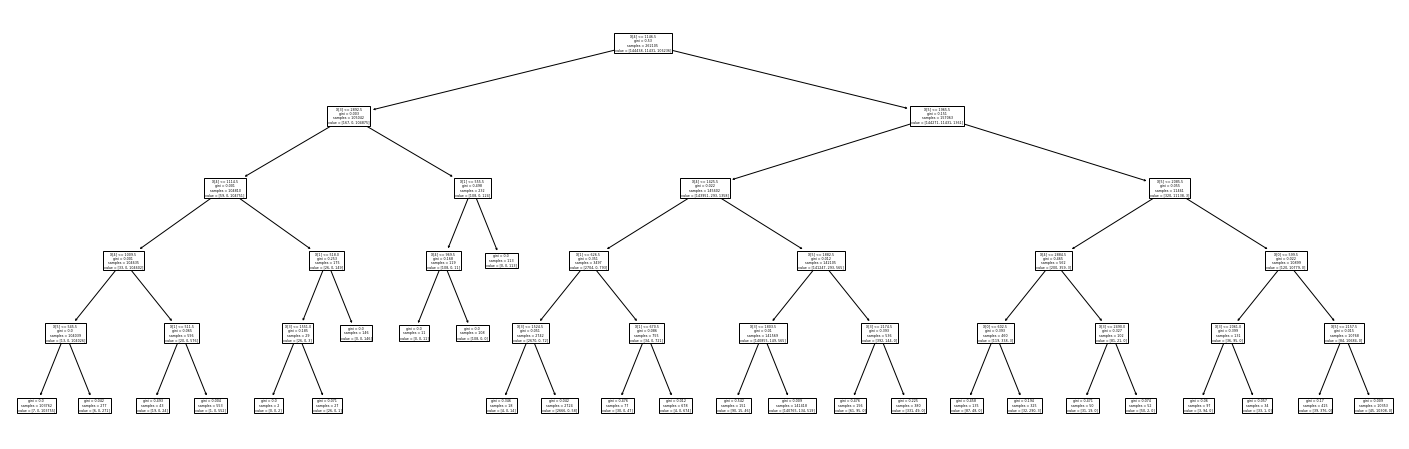

In [244]:
# Plots the structure of the tree
plt.figure(figsize=(25,8))
sklearn.tree.plot_tree(model) 

In [228]:
predict_out = model.predict(model_input[:,1:])

# Prediction

In [245]:
# load the area you want to predict land cover here

# Lake Eyre
# x = (550000, 600000)
# y = (-3000000, -2950000)
# x = (-1000000, -950000)
# y = (-3400000, -3350000)
# x = (-1200000, -1299850)
# y = (-3600000, -3500125)

# # Coorong
# x = (600000, 700000)
# y = (-3950000, -3850000)

# Kakadu
x = (0,100000)
y = (-1350000,-1250000)

query = {'time': ('2015-01-01', '2015-02-01')}
query['x'] = (x[0], x[1])
query['y'] = (y[0], y[1])
query['crs'] = 'EPSG:3577'

In [246]:
display_map(x, y, crs="EPSG:3577")

In [247]:
new_data = dc.load(product=product, group_by='solar_day', **query)

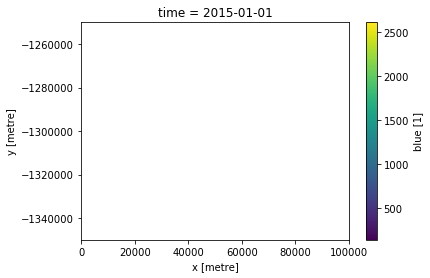

In [251]:
new_data.blue.isel(time=0).plot()

In [58]:
new_data = calculate_indices(new_data, 'BUI', collection='ga_ls_2')
new_data = calculate_indices(new_data, 'BSI', collection='ga_ls_2')
new_data = calculate_indices(new_data, 'BSI', collection='ga_ls_2')
new_data = calculate_indices(new_data, 'NBI', collection='ga_ls_2')
new_data = calculate_indices(new_data, 'EVI', collection='ga_ls_2')
new_data = calculate_indices(new_data, 'NDWI', collection='ga_ls_2')
new_data = calculate_indices(new_data, 'MSAVI', collection='ga_ls_2')
# new_data = new_data.drop(bands)

In [252]:
predicted = dea_classificationtools.predict_xr(model, new_data)

In [253]:
out = predicted.isel(time=0).transpose()
out = out.to_dataset(name="LCCS_L3")
out.attrs['crs']=geometry.CRS(data.crs)
# out = out.isel(time=0)

In [254]:
helpers.write_geotiff('dtreekak.tif', out)

# Clustering method

In [9]:
min_dist = np.empty(len(shp))
for i, feature in enumerate(shp):
    print(i)
    min_dist[i] = np.min([feature.distance(feature) for feature_2 in shp])
df_dist['min_dist_to_lines'] = min_dist

0


AttributeError: 'str' object has no attribute 'distance'